In [2]:
import napari
import h5py
import tifffile
import flimlib
import numpy as np
from napari.qt import thread_worker
import time
from matplotlib.backends.backend_qt5agg import FigureCanvas
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import math

In [4]:
hf1 = h5py.File('data_ch2_med_photons.h5', 'r') # change filename
keys= [key for key in hf1.keys()]

def fit_RLD(exp_curve):
    rld_result = flimlib.GCI_triple_integral_fitting_engine(1.0,exp_curve,chisq_target=1.0) # take the peak and call that the start for the sum of all pixel. can choose start and end
    return(rld_result.tau, rld_result.A, rld_result.chisq)

def update_window():
    
    display = np.array(cumulative_tau_display)
    tau_layer.contrast_limits = (0,display.max()) # must happen before setting layer.data
    tau_layer.data = display
    
    display = np.array(cumulative_A_display)
    A_layer.contrast_limits = (0,display.max()) # must happen before setting layer.data
    A_layer.data = display
    
    display = np.array(cumulative_chisq_display)
    chisq_layer.contrast_limits = (0,display.max()) # must happen before setting layer.data
    chisq_layer.data = display
    
    
    
    viewer.dims.set_current_step(0,len(display)) # view the most recent RLD result
    
    update_plots(None)

def update_plots(event):
    step = viewer.dims.current_step[0]
    
    ax1.clear()
    time_bins = len(cumulative_fitted_hist[step])
    ax1.bar(range(time_bins),cumulative_fitted_hist[step])
    ax1.bar(range(time_bins),cumulative_not_fitted_hist[step])
    
    display = np.array(cumulative_tau_display)
    ax2.clear()
    ax2.hist(display[step][display[step]>0],bins=100) # only nonzero taus
    
    canvas.draw()
    #canvas.flush_events()

@thread_worker(connect={'yielded': update_window})
def stack_pipeline(stacks):
    for stack in stacks:
        process_stack(stack)
        yield
    print("done")
    
def process_stack(stack):
    global cumulative_tau_display
    global cumulative_A_display
    global cumulative_chisq_display
    global cumulative_fitted_hist
    global cumulative_not_fitted_hist
    # what should be used to find fit start and fit end in general?
    fit_start = 50
    fit_end = 210
    fit_data = np.array(stack)[:,:,fit_start:fit_end]

    flim_py = np.apply_along_axis(fit_RLD,2,fit_data)
    tau_matrix = flim_py[:,:,0]
    tau_threshold = 10 # not a great way of finding outliers but this works for now
    tau_matrix[tau_matrix>tau_threshold] = 0 
    cumulative_tau_display += [tau_matrix.tolist()]
    
    A_matrix = flim_py[:,:,1]
    A_threshold = 10
    A_matrix[A_matrix>A_threshold] = 0 
    cumulative_A_display += [A_matrix.tolist()]
    
    chisq_matrix = flim_py[:,:,2]
    print(fit_data[np.where(np.isnan(chisq_matrix))].tolist())
    #print(np.where(np.isnan(chisq_matrix)))
    chisq_matrix[np.isnan(chisq_matrix)] = 0
    chisq_threshold = 100
    chisq_matrix[chisq_matrix>chisq_threshold] = 0 
    cumulative_chisq_display += [chisq_matrix.tolist()]

    fitted_hist = stack.sum((0,1))
    fitted_hist[list(range(fit_start))+list(range(fit_end,len(fitted_hist)))] = 0
    cumulative_fitted_hist += [fitted_hist]
    not_fitted_hist = stack.sum((0,1))
    not_fitted_hist[range(fit_start,fit_end)] = 0
    cumulative_not_fitted_hist += [not_fitted_hist]


In [6]:
# check if viewer is already open
# if yes: close and reopen
try:
    if viewer:
        viewer.close()
except:
    print("viewer already closed or never opened")
viewer = napari.Viewer(ndisplay=2)
empty = np.zeros((256,256))
tau_layer = viewer.add_image(empty, name = "lifetimes")
A_layer = viewer.add_image(empty, name = "intensities")
chisq_layer = viewer.add_image(empty, name = "Χ² scores")

canvas = FigureCanvas(Figure(figsize=(5, 3)))
(ax1, ax2) = canvas.figure.subplots(1,2)
viewer.window.add_dock_widget(canvas, area='bottom', name='matplotlib figure')    
viewer.dims.events.current_step.connect(update_plots,position='last')

simulated_input = np.cumsum([np.array(hf1.get(keys[i])) for i in range(3)],axis=0) # histograms arrive summed with previous

# global display data so it doesn't need to be recalculated
cumulative_fitted_hist = []
cumulative_not_fitted_hist = []
cumulative_tau_display = []
cumulative_A_display = []
cumulative_chisq_display = []

worker = stack_pipeline(simulated_input)

napari.run()

viewer already closed or never opened
[]
[]
[]
done


In [13]:
a = np.array([3,4,5])
b = [True,False,True]
a[np.where(b)]

array([3, 5])

In [62]:
tau_layer.contrast_limits = (1,10)

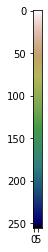

In [66]:
plt.imshow(np.linspace(0,256,2560).reshape([256,10]), cmap='gist_earth_r')

# Test in main thread

In [5]:
stack1 = np.array(hf1.get(keys[0]))
stack2 = np.array(hf1.get(keys[1]))
# check if viewer is already open
# if yes: close and reopen
try:
    if viewer:
        viewer.close()
except:
    print("viewer already closed or never opened")
viewer = napari.Viewer(ndisplay=2)
empty = np.zeros((256,256))
tau_layer = viewer.add_image(empty, name = "lifetimes")
A_layer = viewer.add_image(empty, name = "intensities")
chisq_layer = viewer.add_image(empty, name = "Χ² scores")

canvas = FigureCanvas(Figure(figsize=(5, 3)))
(ax1, ax2) = canvas.figure.subplots(1,2)
viewer.window.add_dock_widget(canvas, area='bottom', name='matplotlib figure')
viewer.dims.events.current_step.connect(update_plots,position='last')

cumulative_fitted_hist = []
cumulative_not_fitted_hist = []
cumulative_tau_display = []
cumulative_A_display = []
cumulative_chisq_display = []

process_stack(stack1)
update_window()


viewer already closed or never opened
[]


In [155]:
update_window(process_stack(stack2))

In [45]:
a = [0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

b = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
len(a)

fit_RLD(a)

(0.6577898263931274, 0.5793812870979309, 7.025399208068848)

In [58]:
rld_result = flimlib.GCI_triple_integral_fitting_engine(0.08,a,chisq_target=1.0)
rld_result.chisq

7.025399208068848

In [1]:
import napari
import numpy as np
from skimage import data

viewer = napari.view_image(data.astronaut(), rgb=True)
points = np.array([[100, 100], [200, 200], [300, 100]])

points_layer = viewer.add_points(points, size=30)